In [1]:
import os
import sys
import json
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from random import randint
import matplotlib.pyplot as plt
from tqdm import tqdm

sys.path.append(os.path.abspath('../'))
from Agent import MLPNetwork

/home/vateseifelfrej/anaconda3/envs/maddpg/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'


# directory with model weights
model_dir = os.path.join(os.path.abspath('../'), 'results/','simple_reference_v2/', "13")
assert os.path.exists(model_dir), f'{model_dir} doesnt exist'
weights = torch.load(os.path.join(model_dir, 'model.pt'), map_location=torch.device(device))

# read config file with env params
with open(os.path.join(model_dir, 'config.json'), 'r') as f:
  cfg = json.load(f)


# training params
batch_size = 1

alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
# number of tokens in alphabet                    
n_tokens = len(alphabet)

# dimension of goal id (RGB color of landmarks)
n_goal_id = 3

num_agents = cfg['num_agents']
num_landmarks = cfg['num_landmarks']

# I/O of speaker and listener
speaker_in = n_goal_id
speaker_out = n_tokens
listener_in = 2 + 2*num_landmarks + n_tokens + n_goal_id
listener_out = 2

In [3]:
# init env observations

# landamrk colors
landmarks_c = sns.color_palette(n_colors=num_landmarks)
landmarks_c = torch.tensor(landmarks_c).unsqueeze(1)
# landmarks positions
landmarks_p = ((torch.rand((batch_size, 2*num_landmarks)) - 0.5) * 2)
landmarks_xy = landmarks_p.reshape(batch_size, num_landmarks, 2)
# velocity of listener
vel = torch.rand((batch_size, 2))

Text(0.5, 1.0, 'Color palette')

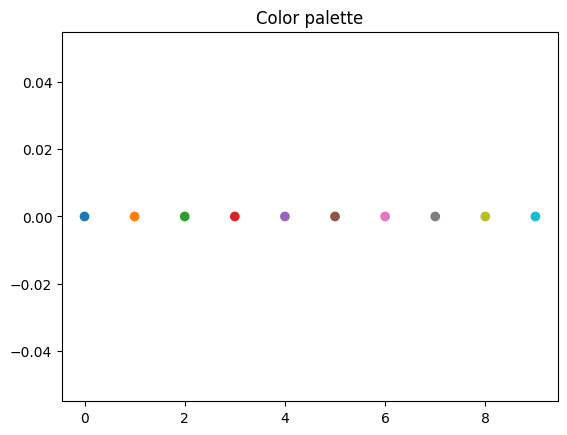

In [4]:
plt.scatter(list(range(num_landmarks)), [0 for _ in range(num_landmarks)], marker='o', c=landmarks_c.squeeze())
plt.title('Color palette')


In [5]:
# init speaker and listener
speaker = MLPNetwork(speaker_in, speaker_out)
speaker.load_state_dict(weights['speaker'])
listener = MLPNetwork(listener_in, listener_out)
listener.load_state_dict(weights['listener'])

<All keys matched successfully>

In [6]:
# letters used for which landmark color by speaker
msgLandmarkMap = {i: [] for  i in range(len(alphabet))}
for i in range(num_landmarks):
  msg = F.gumbel_softmax(speaker(landmarks_c[i]), hard=True)
  li = msg[0].argmax().item()
  msgLandmarkMap[li].append(i)

def computeCentroid(msg):
  """Given a message (the argmax) it checks which other landmarks use the same msg and computes the centroid and the mean color"""
  xy = torch.mean(landmarks_xy[:,msgLandmarkMap[msg]], dim=1)
  c = torch.mean(landmarks_c[msgLandmarkMap[msg]], dim=0)
  return xy, c

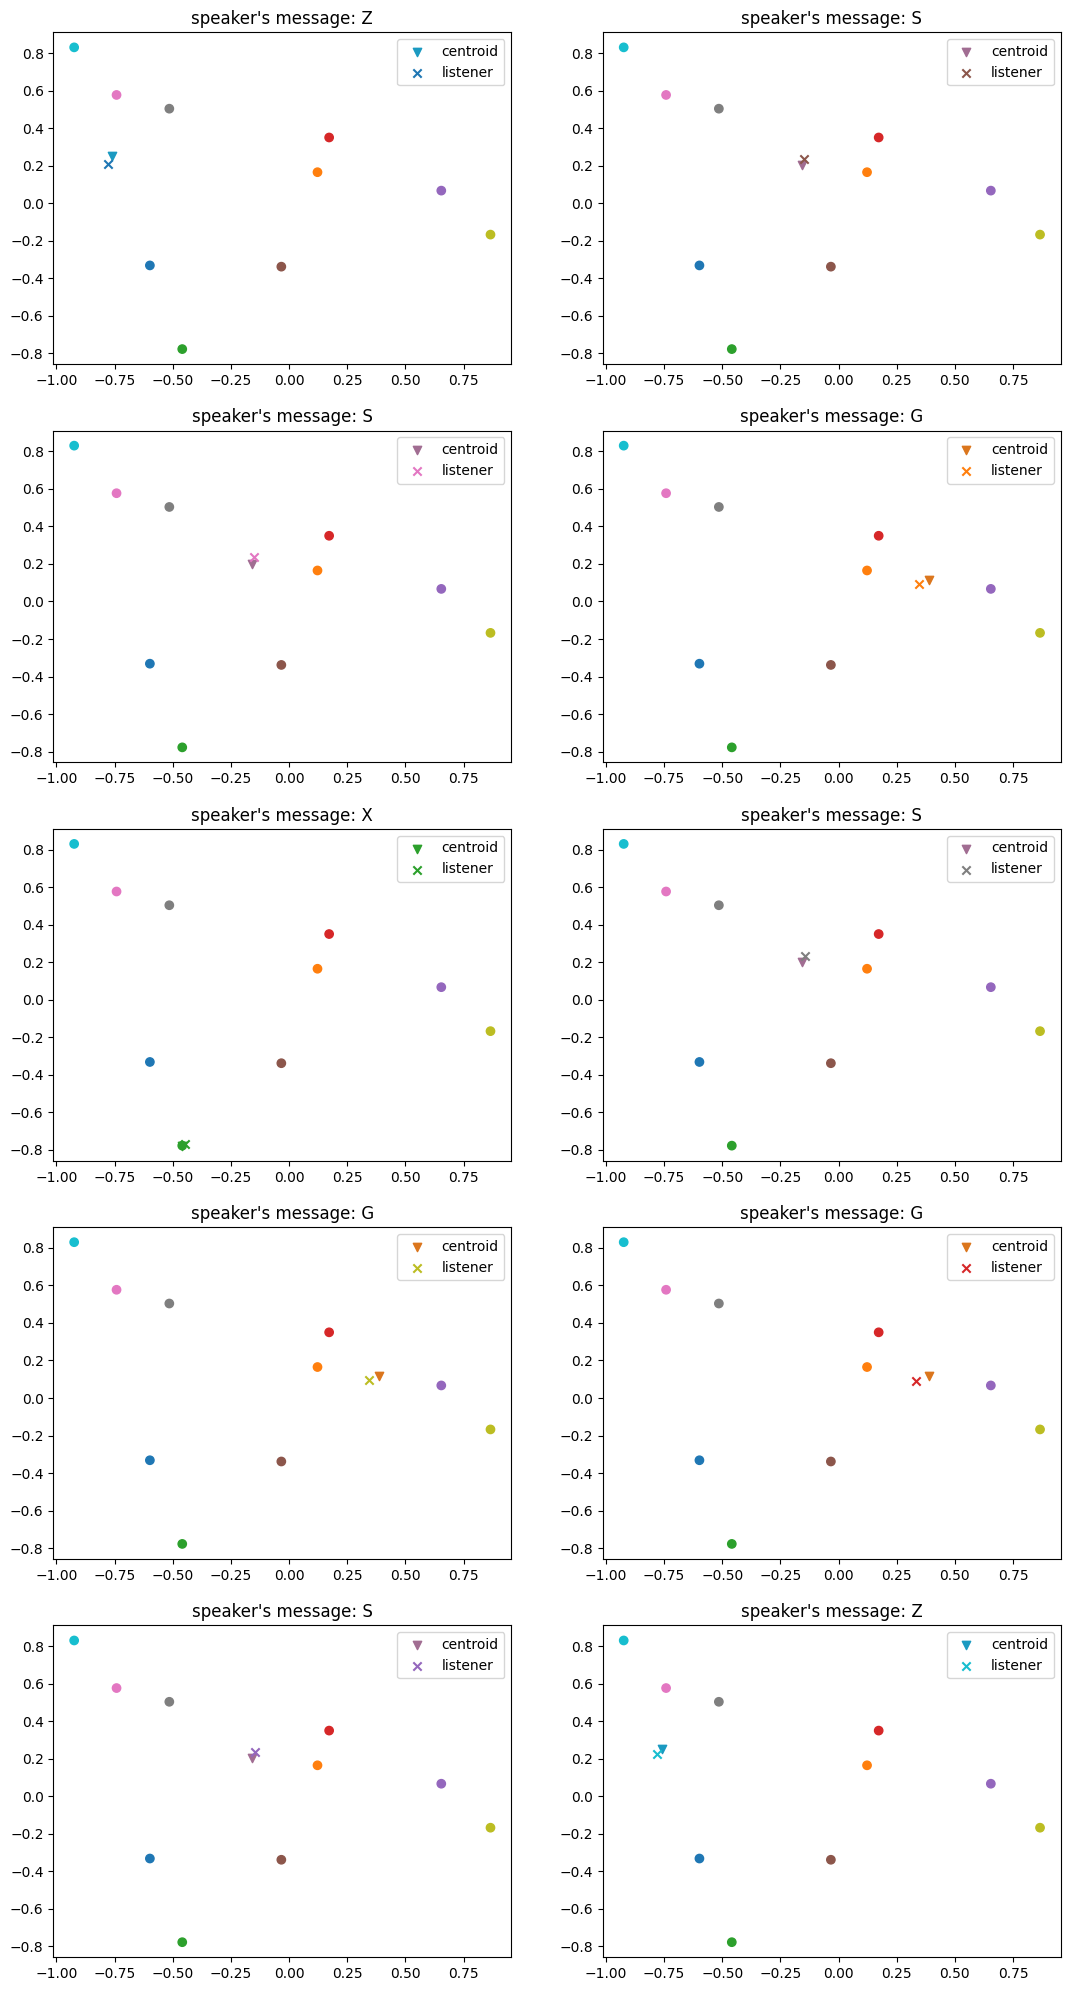

In [7]:
fig, ax = plt.subplots(nrows=int(num_landmarks/2), ncols=2, figsize=(13, 25))

for ix in range(num_landmarks):
  vel = torch.rand((batch_size, 2))
  # sample target landmark
  #ix = randint(0, num_landmarks-1)
  # pass through observer
  msg = F.gumbel_softmax(speaker(landmarks_c[ix].repeat(batch_size, 1)), hard=True)
  # goal id (kinda useless to have it)
  goal_id = torch.cat(list(landmarks_c[randint(0, num_landmarks-1)] for _ in range(batch_size)), 0)
  # listener observation
  obs = torch.cat((vel, landmarks_p, goal_id, msg), 1)  
  # predict landmark pos
  action = listener(obs)
  # compute centroid of chosen message
  centroid_xy, centroid_c = computeCentroid(msg.argmax().item())


  #plt.figure()
  ax[ix%int(num_landmarks/2)][ix%2].scatter([l for i, l in enumerate(landmarks_p[0]) if i%2==0], [l for i, l in enumerate(landmarks_p[0]) if i%2==1], marker='o', c=landmarks_c.squeeze())
  ax[ix%int(num_landmarks/2)][ix%2].scatter(centroid_xy[0, 0], centroid_xy[0, 1], marker='v', c=centroid_c, label='centroid')
  ax[ix%int(num_landmarks/2)][ix%2].scatter(action[0,0].detach().numpy(), action[0,1].detach().numpy(), marker='x', c=landmarks_c[ix], label='listener')
  ax[ix%int(num_landmarks/2)][ix%2].legend(loc='best')
  ax[ix%int(num_landmarks/2)][ix%2].set_title(f"speaker's message: {alphabet[msg[0].argmax()]}")

#fig.savefig('speaker_listener_centroid.png')

In [14]:
new_speaker = MLPNetwork(speaker_in, speaker_out)
new_listener = MLPNetwork(listener_in, listener_out)
optimizer_s = torch.optim.Adam(new_speaker.parameters(), lr=1e-3)
optimizer_l = torch.optim.Adam(new_listener.parameters(), lr=1e-3)

In [15]:
loss_history_s = []
loss_history_l = []

loss_fun_s = nn.NLLLoss()
loss_fun_l = nn.MSELoss()

batch_size = 64

for i in tqdm(range(2000)):
  # sample target landmark indices
  ids = torch.randint(num_landmarks, (batch_size,))
  # speaker input
  goal_landmarks = (landmarks_c.repeat(batch_size, 1, 1)[ids]).squeeze(1)
  # pass through observer
  msg = torch.log(F.gumbel_softmax(new_speaker(goal_landmarks), hard=False))

  # backprop
  optimizer_s.zero_grad()
  loss = loss_fun_s(msg, ids)
  loss.backward()
  optimizer_s.step()

  if i%100==0:
    loss_history_s.append(loss.item())

new_speaker.eval()

for i in tqdm(range(8000)):
  # landmarks positions
  landmarks_p = ((torch.rand((batch_size, 2*num_landmarks)) - 0.5) * 2)
  landmarks_xy = landmarks_p.reshape(batch_size, num_landmarks, 2)
  vel = torch.rand((batch_size, 2))
  # sample target landmark indices
  ids = torch.randint(num_landmarks, (batch_size,))
  # speaker input
  goal_landmarks = (landmarks_c.repeat(batch_size, 1, 1)[ids]).squeeze(1)
  # pass through observer
  msg = F.gumbel_softmax(new_speaker(goal_landmarks), hard=True)
  # goal id (kinda useless to have it)
  goal_id = torch.cat(list(landmarks_c[randint(0, num_landmarks-1)] for _ in range(batch_size)), 0)
  # listener observation
  obs = torch.cat((vel, landmarks_p, goal_id, msg), 1)  
  # predict landmark pos
  action = new_listener(obs)

  # backprop
  optimizer_l.zero_grad()
  loss = loss_fun_l(action, landmarks_xy[torch.arange(batch_size), ids])
  loss.backward()
  optimizer_l.step()

  if i%100==0:
    loss_history_l.append(loss.item())


100%|██████████| 8000/8000 [00:13<00:00, 594.91it/s]


Text(0.5, 1.0, 'Supervised learning speaker')

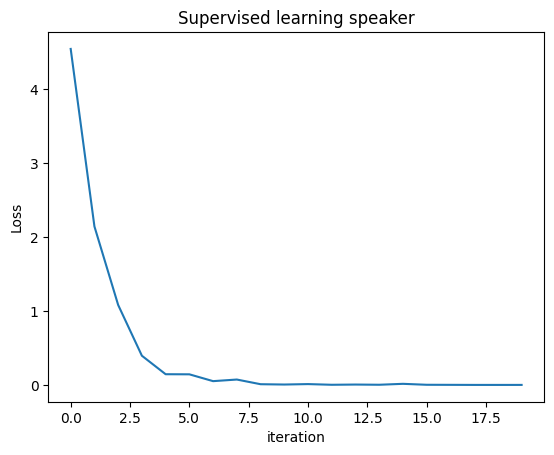

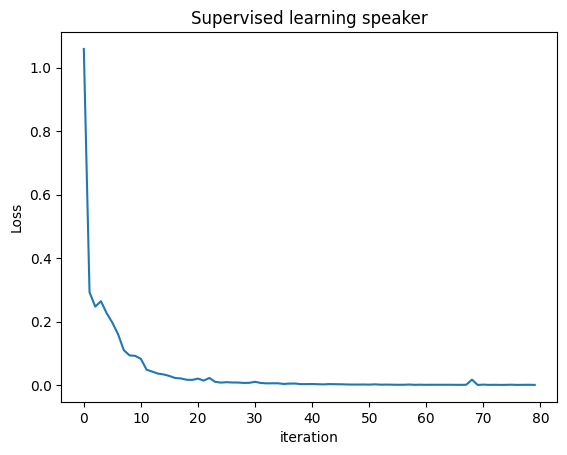

In [16]:
plt.figure()
plt.plot(loss_history_s)
plt.ylabel("Loss")
plt.xlabel("iteration")
plt.title("Supervised learning speaker")

plt.figure()
plt.plot(loss_history_l)
plt.ylabel("Loss")
plt.xlabel("iteration")
plt.title("Supervised learning speaker")

In [26]:
for i in range(num_landmarks):
  msg = F.gumbel_softmax(new_speaker(landmarks_c[i]), hard=True)
  print(msg[0].argmax().item(), i)

0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9


In [27]:
batch_size = 1

# landmarks positions
landmarks_p = ((torch.rand((batch_size, 2*num_landmarks)) - 0.5) * 2)
landmarks_xy = landmarks_p.reshape(batch_size, num_landmarks, 2)

# letters used for which landmark color by speaker
new_msgLandmarkMap = {i: [] for  i in range(len(alphabet))}
for i in range(num_landmarks):
  msg = F.gumbel_softmax(new_speaker(landmarks_c[i]), hard=True)
  li = msg[0].argmax().item()
  new_msgLandmarkMap[li].append(i)

def computeCentroid(msg):
  """Given a message (the argmax) it checks which other landmarks use the same msg and computes the centroid and the mean color"""
  xy = torch.mean(landmarks_xy[:,new_msgLandmarkMap[msg]], dim=1)
  c = torch.mean(landmarks_c[new_msgLandmarkMap[msg]], dim=0)
  return xy, c


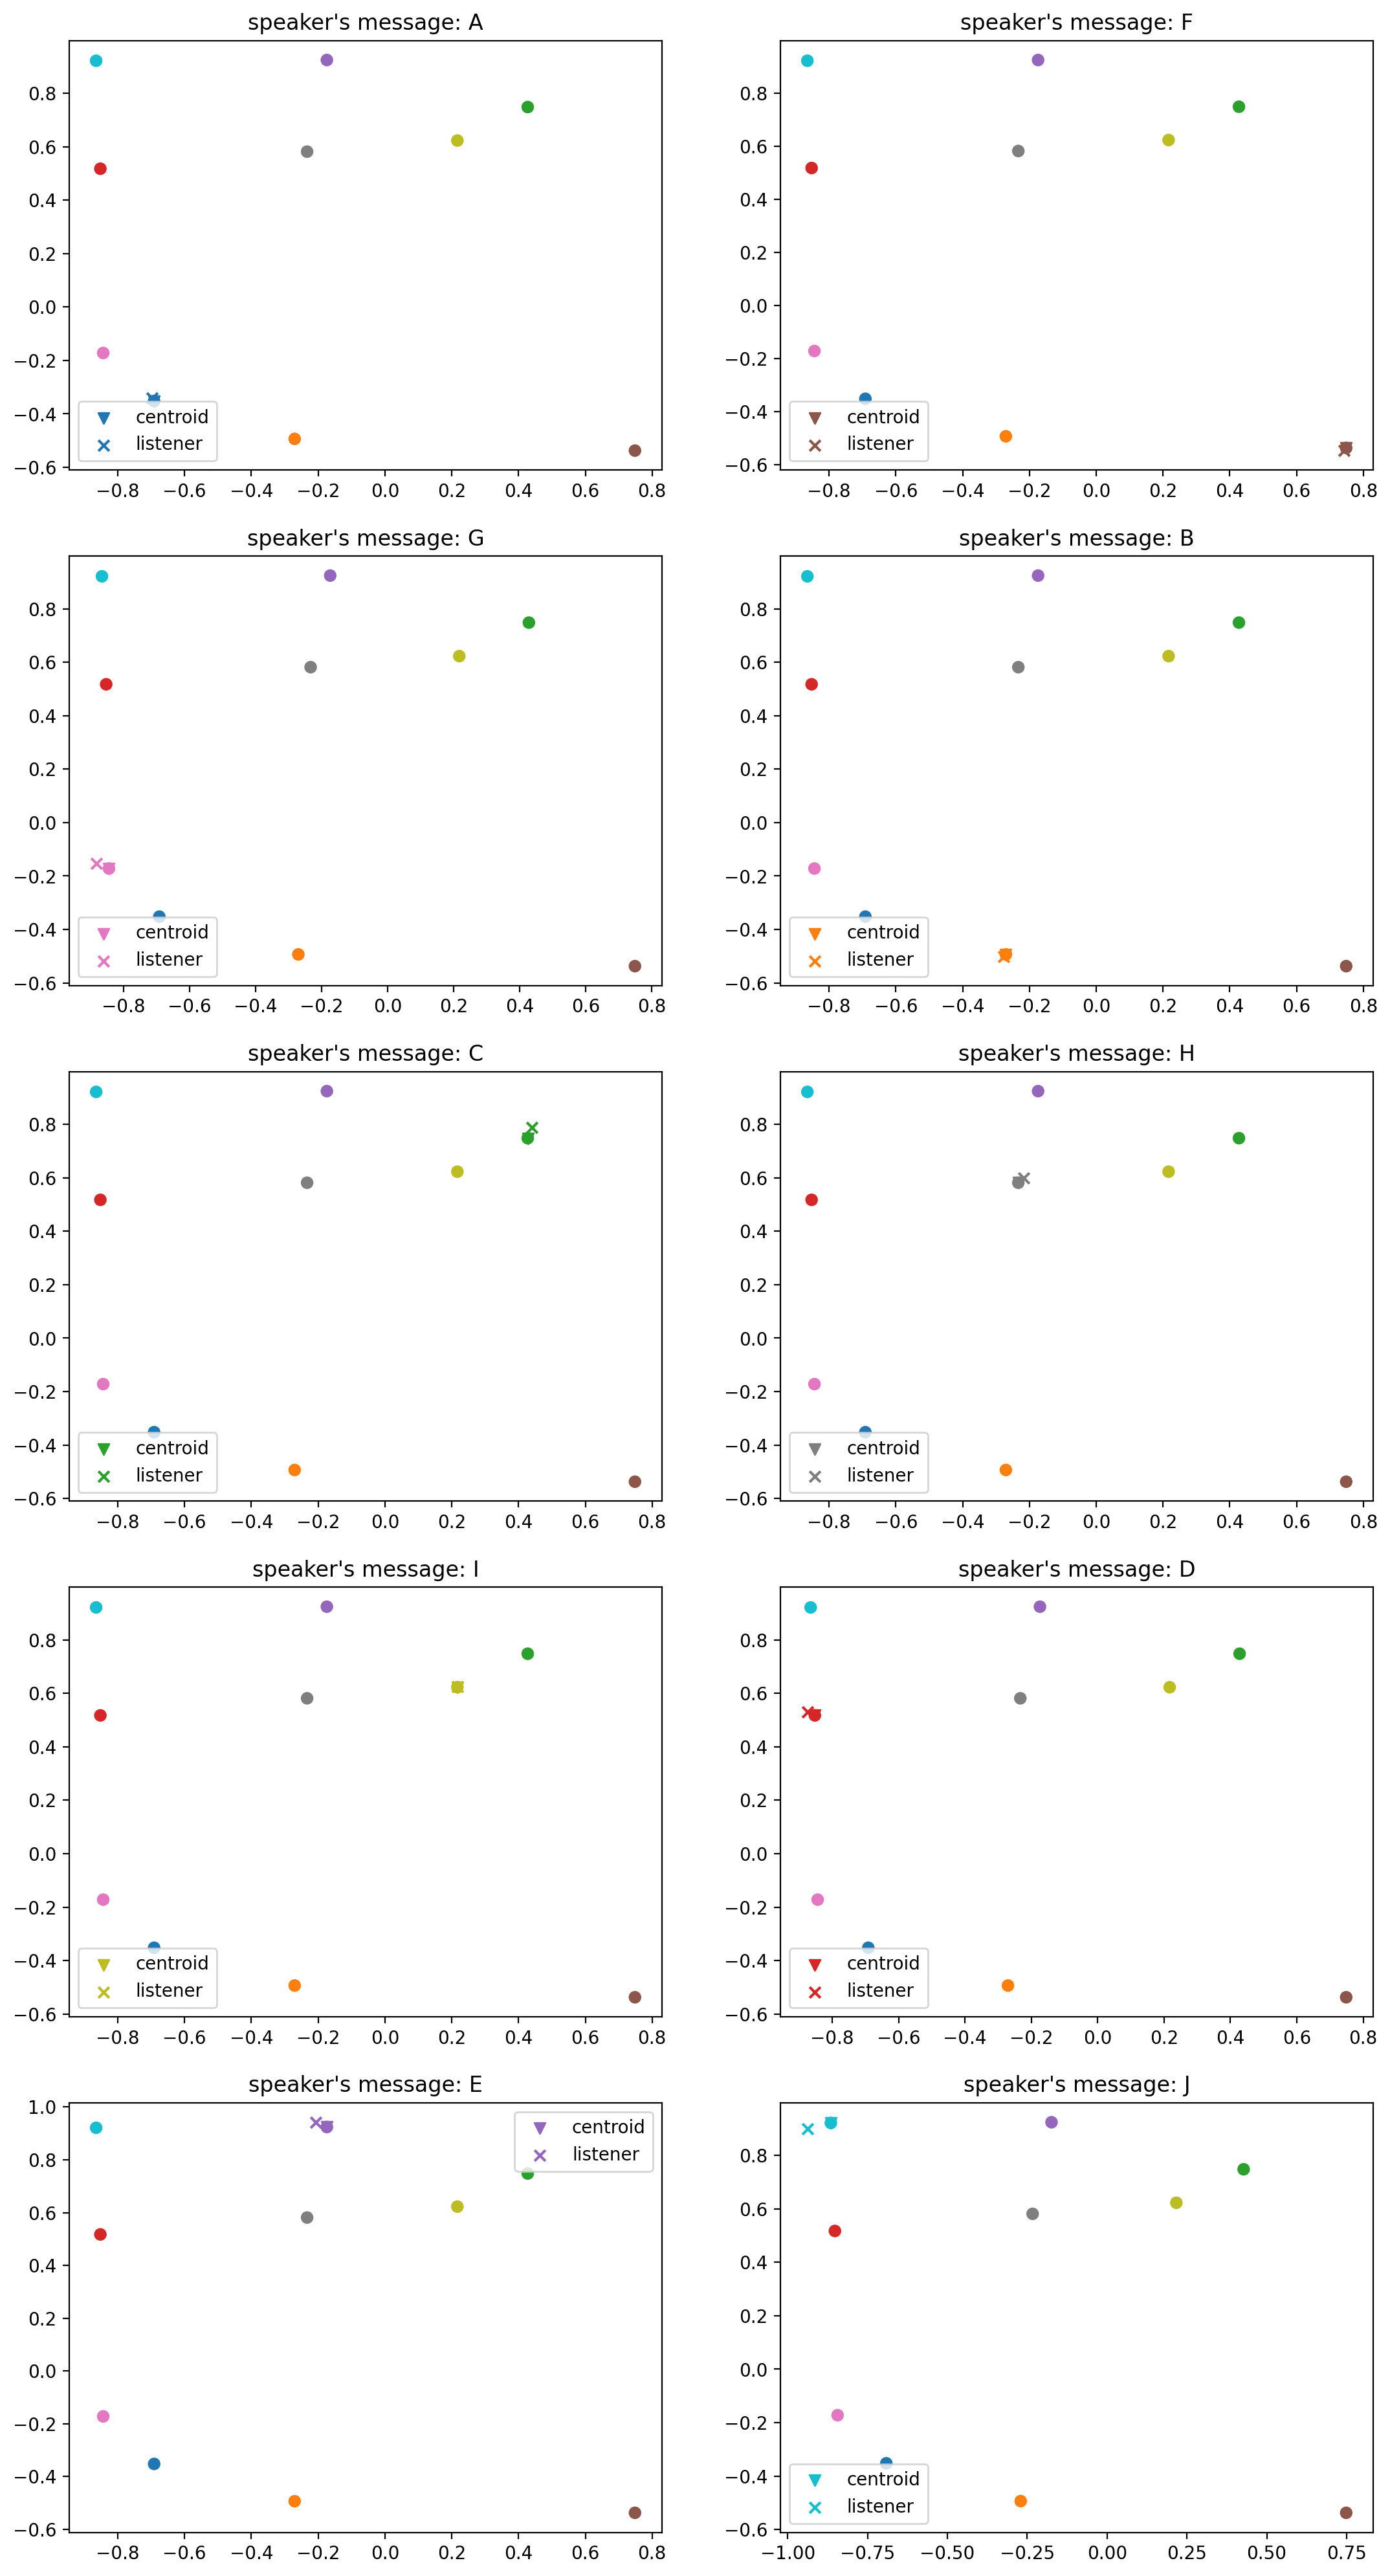

In [28]:
fig, ax = plt.subplots(nrows=int(num_landmarks/2), ncols=2, figsize=(13, 25))#, dpi=200)

batch_size=1
for ix in range(num_landmarks):
  vel = torch.rand((batch_size, 2))
  # sample target landmark
  #ix = randint(0, num_landmarks-1)
  # pass through observer
  msg = F.gumbel_softmax(new_speaker(landmarks_c[ix].repeat(batch_size, 1)), hard=True)
  # goal id (kinda useless to have it)
  goal_id = torch.cat(list(landmarks_c[randint(0, num_landmarks-1)] for _ in range(batch_size)), 0)
  # listener observation
  obs = torch.cat((vel, landmarks_p, goal_id, msg), 1)  
  # predict landmark pos
  action = new_listener(obs)
  # compute centroid of chosen message
  centroid_xy, centroid_c = computeCentroid(msg.argmax().item())


  #plt.figure()
  ax[ix%int(num_landmarks/2)][ix%2].scatter([l for i, l in enumerate(landmarks_p[0]) if i%2==0], [l for i, l in enumerate(landmarks_p[0]) if i%2==1], marker='o', c=landmarks_c.squeeze())
  ax[ix%int(num_landmarks/2)][ix%2].scatter(centroid_xy[0, 0], centroid_xy[0, 1], marker='v', c=centroid_c, label='centroid')
  ax[ix%int(num_landmarks/2)][ix%2].scatter(action[0,0].detach().numpy(), action[0,1].detach().numpy(), marker='x', c=landmarks_c[ix], label='listener')
  ax[ix%int(num_landmarks/2)][ix%2].legend(loc='best')
  ax[ix%int(num_landmarks/2)][ix%2].set_title(f"speaker's message: {alphabet[msg[0].argmax()]}")

#fig.savefig('supervised_speaker_listener_centroid.png')

In [ ]:
# compute similarity of all colors

def ColorDistance(rgb1,rgb2):
  '''d = {} distance between two colors(3)'''
  rm = 0.5*(rgb1[0]+rgb2[0])
  d = sum((2+rm,4,3-rm)*(rgb1-rgb2)**2)**0.5
  return d/3.0 # normalize by 3.0 which is the maximum color distance (white vs black)


thresh = 0.25
similarColorx = []
similarColory = []
similarColorc = []
for i in range(num_landmarks):
  ci = landmarks_c[i].squeeze().detach().numpy()
  for j in range(num_landmarks):
    if i==j: continue
    cj = landmarks_c[j].squeeze().detach().numpy()
    dij = ColorDistance(ci, cj)
    if dij < thresh:
      # compute weighted centroid between 2 points
      px = (landmarks_p[0, i*2] + (1-dij)*landmarks_p[0, j*2])/(2-dij)
      py = (landmarks_p[0, i*2+1] + (1-dij)*landmarks_p[0, j*2+1])/(2.-dij)
      similarColorx.append(px)
      similarColory.append(py)
      similarColorc.append(((ci+cj)/2.0).tolist())

In [ ]:
plt.scatter([l for i, l in enumerate(landmarks_p[0]) if i%2==0], [l for i, l in enumerate(landmarks_p[0]) if i%2==1], marker='o', c=landmarks_c.squeeze())
plt.scatter(similarColorx, similarColory, marker='.', c=similarColorc)
plt.scatter(action[0,0].detach().numpy(), action[0,1].detach().numpy(), marker='x', c=landmarks_c[ix])